# LSTM

In [5]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

In [9]:
x       = pickle.load(open("HargaSaham.dat", "rb"))   #input dataset
xs      = (x-x.min())/(x.max()-x.min())   #Standarized the dataset
N       = xs.shape[0]

#hypreparameter
nc      = 4  
Ts      = 5
x_dim   = 1
alpha   = 0.01
epochs  = 5000

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   

X_train = xt[:-30, 0:x_dim]     
y_train = xt[:-30, x_dim:x_dim+1]  
X_test = xt[-30:, 0:x_dim]     
y_test = xt[-30:, x_dim:x_dim+1]  

In [10]:
me = LSTM(x_dim,1,nc)
for i in range(5000):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.05689490303867713
------------- 2 -------------
0.06128216375410757
------------- 3 -------------
0.06133170750482643
------------- 4 -------------
0.06132400511465377
------------- 5 -------------
0.061315548578705574
------------- 6 -------------
0.06130708343507773
------------- 7 -------------
0.0612986195018388
------------- 8 -------------
0.061290156887347604
------------- 9 -------------
0.061281695571850155
------------- 10 -------------
0.06127323553393173
------------- 11 -------------
0.06126477675218492
------------- 12 -------------
0.06125631920523185
------------- 13 -------------
0.06124786287172185
------------- 14 -------------
0.06123940773033163
------------- 15 -------------
0.06123095375976474
------------- 16 -------------
0.0612225009387493
------------- 17 -------------
0.0612140492460377
------------- 18 -------------
0.061205598660406674
------------- 19 -------------
0.061197149160654545
------------- 20 -------------
0.06118

0.06000649147922861
------------- 161 -------------
0.05999797725011586
------------- 162 -------------
0.0599894609029853
------------- 163 -------------
0.05998094241168667
------------- 164 -------------
0.059972421749985176
------------- 165 -------------
0.05996389889156192
------------- 166 -------------
0.05995537381001257
------------- 167 -------------
0.05994684647884721
------------- 168 -------------
0.059938316871489636
------------- 169 -------------
0.059929784961275934
------------- 170 -------------
0.05992125072145556
------------- 171 -------------
0.05991271412518926
------------- 172 -------------
0.059904175145549035
------------- 173 -------------
0.059895633755517735
------------- 174 -------------
0.05988708992798825
------------- 175 -------------
0.0598785436357627
------------- 176 -------------
0.059869994851552304
------------- 177 -------------
0.05986144354797627
------------- 178 -------------
0.05985288969756203
------------- 179 -------------
0.059844

0.0585692836454373
------------- 324 -------------
0.0585600033878759
------------- 325 -------------
0.05855071524667389
------------- 326 -------------
0.05854141917483453
------------- 327 -------------
0.05853211512519371
------------- 328 -------------
0.05852280305041905
------------- 329 -------------
0.058513482903009756
------------- 330 -------------
0.058504154635295666
------------- 331 -------------
0.05849481819943809
------------- 332 -------------
0.058485473547427384
------------- 333 -------------
0.05847612063108445
------------- 334 -------------
0.05846675940205911
------------- 335 -------------
0.05845738981183089
------------- 336 -------------
0.058448011811706994
------------- 337 -------------
0.058438625352823174
------------- 338 -------------
0.05842923038614286
------------- 339 -------------
0.0584198268624564
------------- 340 -------------
0.058410414732381614
------------- 341 -------------
0.05840099394636265
------------- 342 -------------
0.0583915

0.05691411901786474
------------- 487 -------------
0.056902803995913034
------------- 488 -------------
0.056891470969743035
------------- 489 -------------
0.05688011986094601
------------- 490 -------------
0.056868750590910615
------------- 491 -------------
0.056857363080822065
------------- 492 -------------
0.05684595725166396
------------- 493 -------------
0.056834533024217544
------------- 494 -------------
0.05682309031906121
------------- 495 -------------
0.05681162905657208
------------- 496 -------------
0.05680014915692544
------------- 497 -------------
0.056788650540094944
------------- 498 -------------
0.056777133125853
------------- 499 -------------
0.05676559683377127
------------- 500 -------------
0.05675404158321982
------------- 501 -------------
0.056742467293368876
------------- 502 -------------
0.05673087388318799
------------- 503 -------------
0.05671926127144692
------------- 504 -------------
0.05670762937671531
------------- 505 -------------
0.05669

0.05484771334108367
------------- 645 -------------
0.05483246205268749
------------- 646 -------------
0.05481717822219187
------------- 647 -------------
0.05480186174843011
------------- 648 -------------
0.05478651253021607
------------- 649 -------------
0.05477113046634649
------------- 650 -------------
0.05475571545560426
------------- 651 -------------
0.05474026739675999
------------- 652 -------------
0.054724786188575326
------------- 653 -------------
0.054709271729806004
------------- 654 -------------
0.05469372391920409
------------- 655 -------------
0.05467814265552084
------------- 656 -------------
0.054662527837510064
------------- 657 -------------
0.05464687936392987
------------- 658 -------------
0.05463119713354697
------------- 659 -------------
0.054615481045138366
------------- 660 -------------
0.05459973099749492
------------- 661 -------------
0.05458394688942367
------------- 662 -------------
0.05456812861975163
------------- 663 -------------
0.054552

0.05197120678738863
------------- 803 -------------
0.05194963305662004
------------- 804 -------------
0.051928012933658604
------------- 805 -------------
0.05190634636443885
------------- 806 -------------
0.051884633295623386
------------- 807 -------------
0.051862873674609976
------------- 808 -------------
0.051841067449538106
------------- 809 -------------
0.051819214569294746
------------- 810 -------------
0.05179731498352172
------------- 811 -------------
0.05177536864262141
------------- 812 -------------
0.05175337549776426
------------- 813 -------------
0.05173133550089411
------------- 814 -------------
0.05170924860473569
------------- 815 -------------
0.05168711476280089
------------- 816 -------------
0.05166493392939479
------------- 817 -------------
0.05164270605962299
------------- 818 -------------
0.051620431109397374
------------- 819 -------------
0.05159810903544346
------------- 820 -------------
0.051575739795306295
------------- 821 -------------
0.051

0.04774262911787057
------------- 969 -------------
0.04771334862387265
------------- 970 -------------
0.04768402721407181
------------- 971 -------------
0.04765466503029444
------------- 972 -------------
0.047625262215777425
------------- 973 -------------
0.047596056818062955
------------- 974 -------------
0.04756690015350706
------------- 975 -------------
0.04753770395573485
------------- 976 -------------
0.047508468372334356
------------- 977 -------------
0.04747919355227371
------------- 978 -------------
0.047449879645899085
------------- 979 -------------
0.04742052680493185
------------- 980 -------------
0.04739113518246613
------------- 981 -------------
0.04736170493296688
------------- 982 -------------
0.04733223621226667
------------- 983 -------------
0.04730272917756326
------------- 984 -------------
0.047273183987416464
------------- 985 -------------
0.04724360080174559
------------- 986 -------------
0.04721397978182649
------------- 987 -------------
0.04718

0.042947649607683366
------------- 1126 -------------
0.04291589615371558
------------- 1127 -------------
0.04288413842188388
------------- 1128 -------------
0.042852376680585884
------------- 1129 -------------
0.04282061119826674
------------- 1130 -------------
0.042788842243409064
------------- 1131 -------------
0.042757070084520024
------------- 1132 -------------
0.04272529499012046
------------- 1133 -------------
0.042693517228732866
------------- 1134 -------------
0.04266173706886956
------------- 1135 -------------
0.042629954779022275
------------- 1136 -------------
0.04259817062764929
------------- 1137 -------------
0.0425663848831643
------------- 1138 -------------
0.04253459781392545
------------- 1139 -------------
0.042502809688223044
------------- 1140 -------------
0.04247102077426859
------------- 1141 -------------
0.04243923134018358
------------- 1142 -------------
0.042407441653986674
------------- 1143 -------------
0.042375651983584534
------------- 1144

0.03832887439606236
------------- 1280 -------------
0.038302604503160816
------------- 1281 -------------
0.03827636268102525
------------- 1282 -------------
0.038250149079910784
------------- 1283 -------------
0.03822396384909463
------------- 1284 -------------
0.038197807136875254
------------- 1285 -------------
0.03817167909057069
------------- 1286 -------------
0.03814557985651792
------------- 1287 -------------
0.03811950958007046
------------- 1288 -------------
0.03809346840559795
------------- 1289 -------------
0.038067456476484116
------------- 1290 -------------
0.03804147393512678
------------- 1291 -------------
0.03801552092293588
------------- 1292 -------------
0.03798959758033272
------------- 1293 -------------
0.03796370404674932
------------- 1294 -------------
0.03793784046062712
------------- 1295 -------------
0.037912006959416586
------------- 1296 -------------
0.03788620367957618
------------- 1297 -------------
0.03786043075657155
------------- 1298 --

0.03459883579907907
------------- 1438 -------------
0.034578239398742244
------------- 1439 -------------
0.03455768304474246
------------- 1440 -------------
0.03453716674629071
------------- 1441 -------------
0.034516690511928065
------------- 1442 -------------
0.03449625434952908
------------- 1443 -------------
0.03447585826630577
------------- 1444 -------------
0.0344555022688105
------------- 1445 -------------
0.034435186362941135
------------- 1446 -------------
0.03441491055394305
------------- 1447 -------------
0.03439467484641387
------------- 1448 -------------
0.034374479244306776
------------- 1449 -------------
0.034354323750934286
------------- 1450 -------------
0.03433420836897218
------------- 1451 -------------
0.03431413310046293
------------- 1452 -------------
0.034294097946819
------------- 1453 -------------
0.03427410290882732
------------- 1454 -------------
0.034254147986652585
------------- 1455 -------------
0.03423423317984097
------------- 1456 ----

0.03186237829902313
------------- 1594 -------------
0.031847809781754
------------- 1595 -------------
0.03183327683942561
------------- 1596 -------------
0.03181877941816562
------------- 1597 -------------
0.03180431746392533
------------- 1598 -------------
0.031789890922486436
------------- 1599 -------------
0.031775499739460235
------------- 1600 -------------
0.03176114386029113
------------- 1601 -------------
0.03174682323025898
------------- 1602 -------------
0.03173253779448054
------------- 1603 -------------
0.03171828749791224
------------- 1604 -------------
0.03170407228535335
------------- 1605 -------------
0.03168989210144575
------------- 1606 -------------
0.03167574689067848
------------- 1607 -------------
0.031661636597389374
------------- 1608 -------------
0.031647561165765996
------------- 1609 -------------
0.03163352053984914
------------- 1610 -------------
0.03161951466353476
------------- 1611 -------------
0.031605543480575565
------------- 1612 ----

0.029983746431293142
------------- 1753 -------------
0.02997482561137821
------------- 1754 -------------
0.029965928910178897
------------- 1755 -------------
0.029957056271848706
------------- 1756 -------------
0.029948207640587938
------------- 1757 -------------
0.029939382960644568
------------- 1758 -------------
0.02993058217631551
------------- 1759 -------------
0.02992180523194523
------------- 1760 -------------
0.029913052071929066
------------- 1761 -------------
0.0299043226407112
------------- 1762 -------------
0.029895616882787614
------------- 1763 -------------
0.02988693474270487
------------- 1764 -------------
0.029878276165061984
------------- 1765 -------------
0.02986964109451042
------------- 1766 -------------
0.029861029475753947
------------- 1767 -------------
0.029852441253551153
------------- 1768 -------------
0.029843876372714483
------------- 1769 -------------
0.029835334778110692
------------- 1770 -------------
0.029826816414662605
------------- 

0.029046891200406093
------------- 1907 -------------
0.029043076316655134
------------- 1908 -------------
0.029039271994664002
------------- 1909 -------------
0.029035478205946805
------------- 1910 -------------
0.029031694922075007
------------- 1911 -------------
0.029027922114679413
------------- 1912 -------------
0.029024159755449377
------------- 1913 -------------
0.029020407816133336
------------- 1914 -------------
0.029016666268537647
------------- 1915 -------------
0.029012935084527614
------------- 1916 -------------
0.029009214236027377
------------- 1917 -------------
0.029005503695019925
------------- 1918 -------------
0.02900180343354681
------------- 1919 -------------
0.028998113423708144
------------- 1920 -------------
0.02899443363766309
------------- 1921 -------------
0.02899076404762903
------------- 1922 -------------
0.02898710462588299
------------- 1923 -------------
0.028983455344759913
------------- 1924 -------------
0.02897981617665367
------------

0.02855822151993529
------------- 2065 -------------
0.0285557595035873
------------- 2066 -------------
0.02855330426110239
------------- 2067 -------------
0.02855085577286014
------------- 2068 -------------
0.02854841401929115
------------- 2069 -------------
0.028545978980877868
------------- 2070 -------------
0.02854355063815136
------------- 2071 -------------
0.028541128971695473
------------- 2072 -------------
0.028538713962142956
------------- 2073 -------------
0.028536305590177894
------------- 2074 -------------
0.028533903836534515
------------- 2075 -------------
0.02853150868199689
------------- 2076 -------------
0.028529120107399768
------------- 2077 -------------
0.028526738093628
------------- 2078 -------------
0.028524362621615968
------------- 2079 -------------
0.028521993672348152
------------- 2080 -------------
0.028519631226859268
------------- 2081 -------------
0.02851727526623309
------------- 2082 -------------
0.028514925771603427
------------- 2083 

0.028248247550816282
------------- 2219 -------------
0.028246625877863595
------------- 2220 -------------
0.02824500850195057
------------- 2221 -------------
0.02824339541020632
------------- 2222 -------------
0.028241786589797882
------------- 2223 -------------
0.02824018202792801
------------- 2224 -------------
0.028238581711836717
------------- 2225 -------------
0.028236985628800445
------------- 2226 -------------
0.028235393766130868
------------- 2227 -------------
0.028233806111176984
------------- 2228 -------------
0.028232222651323868
------------- 2229 -------------
0.02823064337399173
------------- 2230 -------------
0.028229068266637573
------------- 2231 -------------
0.028227497316754557
------------- 2232 -------------
0.02822593051187061
------------- 2233 -------------
0.028224367839549836
------------- 2234 -------------
0.028222809287392247
------------- 2235 -------------
0.028221254843032683
------------- 2236 -------------
0.02821970449414264
-------------

0.028042219136887626
------------- 2373 -------------
0.02804112754590396
------------- 2374 -------------
0.02804003865150624
------------- 2375 -------------
0.028038952445496798
------------- 2376 -------------
0.02803786891970115
------------- 2377 -------------
0.02803678806597019
------------- 2378 -------------
0.028035709876178455
------------- 2379 -------------
0.028034634342225494
------------- 2380 -------------
0.028033561456033983
------------- 2381 -------------
0.028032491209552198
------------- 2382 -------------
0.028031423594751647
------------- 2383 -------------
0.02803035860362748
------------- 2384 -------------
0.02802929622819956
------------- 2385 -------------
0.02802823646051118
------------- 2386 -------------
0.028027179292629153
------------- 2387 -------------
0.028026124716645166
------------- 2388 -------------
0.028025072724673313
------------- 2389 -------------
0.02802402330885214
------------- 2390 -------------
0.02802297646134303
------------- 23

0.02790149721410998
------------- 2527 -------------
0.0279007374961534
------------- 2528 -------------
0.027899979463464057
------------- 2529 -------------
0.027899223110901962
------------- 2530 -------------
0.02789846843334227
------------- 2531 -------------
0.027897715425676203
------------- 2532 -------------
0.027896964082810793
------------- 2533 -------------
0.027896214399668325
------------- 2534 -------------
0.027895466371186645
------------- 2535 -------------
0.027894719992319506
------------- 2536 -------------
0.027893975258035653
------------- 2537 -------------
0.027893232163319376
------------- 2538 -------------
0.02789249070317046
------------- 2539 -------------
0.027891750872604145
------------- 2540 -------------
0.027891012666650346
------------- 2541 -------------
0.027890276080354773
------------- 2542 -------------
0.027889541108778077
------------- 2543 -------------
0.027888807746996064
------------- 2544 -------------
0.02788807599010006
-------------

0.027799408796316087
------------- 2685 -------------
0.027798860676261958
------------- 2686 -------------
0.027798313597484536
------------- 2687 -------------
0.02779776755682837
------------- 2688 -------------
0.027797222551148457
------------- 2689 -------------
0.02779667857730854
------------- 2690 -------------
0.027796135632183135
------------- 2691 -------------
0.02779559371265566
------------- 2692 -------------
0.027795052815620006
------------- 2693 -------------
0.027794512937978254
------------- 2694 -------------
0.02779397407664399
------------- 2695 -------------
0.027793436228538977
------------- 2696 -------------
0.027792899390594837
------------- 2697 -------------
0.027792363559753227
------------- 2698 -------------
0.02779182873296515
------------- 2699 -------------
0.02779129490719006
------------- 2700 -------------
0.027790762079398422
------------- 2701 -------------
0.0277902302465692
------------- 2702 -------------
0.027789699405690604
------------- 2

0.02772390914094288
------------- 2843 -------------
0.027723492040286134
------------- 2844 -------------
0.027723075586592164
------------- 2845 -------------
0.02772265977793337
------------- 2846 -------------
0.02772224461238854
------------- 2847 -------------
0.02772183008804217
------------- 2848 -------------
0.027721416202985166
------------- 2849 -------------
0.027721002955313906
------------- 2850 -------------
0.027720590343130992
------------- 2851 -------------
0.027720178364545166
------------- 2852 -------------
0.027719767017670618
------------- 2853 -------------
0.027719356300627752
------------- 2854 -------------
0.027718946211542684
------------- 2855 -------------
0.027718536748547563
------------- 2856 -------------
0.027718127909780278
------------- 2857 -------------
0.027717719693384456
------------- 2858 -------------
0.02771731209750938
------------- 2859 -------------
0.02771690512031055
------------- 2860 -------------
0.027716498759949224
-------------

0.027666271034736137
------------- 2997 -------------
0.027665934069842905
------------- 2998 -------------
0.027665597516076345
------------- 2999 -------------
0.027665261372246487
------------- 3000 -------------
0.027664925637167114
------------- 3001 -------------
0.02766459030965726
------------- 3002 -------------
0.027664255388537874
------------- 3003 -------------
0.027663920872634397
------------- 3004 -------------
0.02766358676077601
------------- 3005 -------------
0.02766325305179529
------------- 3006 -------------
0.027662919744528655
------------- 3007 -------------
0.0276625868378161
------------- 3008 -------------
0.027662254330500954
------------- 3009 -------------
0.027661922221430803
------------- 3010 -------------
0.0276615905094564
------------- 3011 -------------
0.027661259193431972
------------- 3012 -------------
0.027660928272216022
------------- 3013 -------------
0.02766059774466995
------------- 3014 -------------
0.02766026760965866
------------- 30

0.027616310489631944
------------- 3159 -------------
0.02761602691303838
------------- 3160 -------------
0.02761574359625785
------------- 3161 -------------
0.027615460538574218
------------- 3162 -------------
0.027615177739274296
------------- 3163 -------------
0.027614895197646414
------------- 3164 -------------
0.02761461291298209
------------- 3165 -------------
0.02761433088457435
------------- 3166 -------------
0.02761404911171858
------------- 3167 -------------
0.02761376759371299
------------- 3168 -------------
0.02761348632985653
------------- 3169 -------------
0.02761320531945177
------------- 3170 -------------
0.027612924561802674
------------- 3171 -------------
0.02761264405621616
------------- 3172 -------------
0.027612363802000293
------------- 3173 -------------
0.027612083798465824
------------- 3174 -------------
0.027611804044925775
------------- 3175 -------------
0.027611524540695466
------------- 3176 -------------
0.027611245285091596
------------- 31

0.027575068590952028
------------- 3314 -------------
0.027574817957965084
------------- 3315 -------------
0.027574567496761834
------------- 3316 -------------
0.027574317206901986
------------- 3317 -------------
0.02757406708794587
------------- 3318 -------------
0.027573817139455503
------------- 3319 -------------
0.027573567360994616
------------- 3320 -------------
0.027573317752127135
------------- 3321 -------------
0.027573068312420176
------------- 3322 -------------
0.02757281904144042
------------- 3323 -------------
0.027572569938756918
------------- 3324 -------------
0.027572321003939786
------------- 3325 -------------
0.027572072236560594
------------- 3326 -------------
0.027571823636191962
------------- 3327 -------------
0.027571575202408244
------------- 3328 -------------
0.02757132693478478
------------- 3329 -------------
0.027571078832898152
------------- 3330 -------------
0.027570830896326694
------------- 3331 -------------
0.027570583124650012
----------

0.027538270327212823
------------- 3470 -------------
0.027538106496633786
------------- 3471 -------------
0.02753794272779959
------------- 3472 -------------
0.027537779020592054
------------- 3473 -------------
0.02753761537489362
------------- 3474 -------------
0.027537451790586805
------------- 3475 -------------
0.027537288267554163
------------- 3476 -------------
0.02753712480567939
------------- 3477 -------------
0.02753696140484606
------------- 3478 -------------
0.027536798064937872
------------- 3479 -------------
0.02753663478583937
------------- 3480 -------------
0.027536471567435127
------------- 3481 -------------
0.02753630840961009
------------- 3482 -------------
0.027536145312249845
------------- 3483 -------------
0.02753598227523982
------------- 3484 -------------
0.027535819298466345
------------- 3485 -------------
0.027535656381815578
------------- 3486 -------------
0.02753549352517433
------------- 3487 -------------
0.027535330728429664
------------- 3

0.02751308281537856
------------- 3628 -------------
0.027512927479190846
------------- 3629 -------------
0.027512772189853155
------------- 3630 -------------
0.027512616947292446
------------- 3631 -------------
0.027512461751434757
------------- 3632 -------------
0.027512306602206733
------------- 3633 -------------
0.027512151499535308
------------- 3634 -------------
0.027511996443347547
------------- 3635 -------------
0.027511841433570848
------------- 3636 -------------
0.02751168647013258
------------- 3637 -------------
0.02751153155296071
------------- 3638 -------------
0.027511376681983023
------------- 3639 -------------
0.027511221857127493
------------- 3640 -------------
0.027511067078323025
------------- 3641 -------------
0.02751091234549747
------------- 3642 -------------
0.02751075765858015
------------- 3643 -------------
0.02751060301750001
------------- 3644 -------------
0.027510448422185987
------------- 3645 -------------
0.027510293872567808
-------------

0.02748952452940379
------------- 3783 -------------
0.027489375691989452
------------- 3784 -------------
0.027489226892205686
------------- 3785 -------------
0.027489078130005392
------------- 3786 -------------
0.027488929405341814
------------- 3787 -------------
0.027488780718167728
------------- 3788 -------------
0.0274886320684366
------------- 3789 -------------
0.027488483456101734
------------- 3790 -------------
0.02748833488111637
------------- 3791 -------------
0.027488186343434508
------------- 3792 -------------
0.02748803784300979
------------- 3793 -------------
0.02748788937979583
------------- 3794 -------------
0.02748774095374702
------------- 3795 -------------
0.02748759256481724
------------- 3796 -------------
0.027487444212960722
------------- 3797 -------------
0.027487295898132137
------------- 3798 -------------
0.027487147620285902
------------- 3799 -------------
0.027486999379376428
------------- 3800 -------------
0.027486851175358748
------------- 3

0.0274668779476923
------------- 3938 -------------
0.027466734452230798
------------- 3939 -------------
0.02746659098845027
------------- 3940 -------------
0.027466447556319572
------------- 3941 -------------
0.027466304155808138
------------- 3942 -------------
0.027466160786885695
------------- 3943 -------------
0.027466017449521075
------------- 3944 -------------
0.02746587414368429
------------- 3945 -------------
0.027465730869344562
------------- 3946 -------------
0.027465587626471756
------------- 3947 -------------
0.027465444415035366
------------- 3948 -------------
0.02746530123500561
------------- 3949 -------------
0.027465158086352123
------------- 3950 -------------
0.027465014969045107
------------- 3951 -------------
0.027464871883054544
------------- 3952 -------------
0.027464728828350476
------------- 3953 -------------
0.027464585804903387
------------- 3954 -------------
0.02746444281268333
------------- 3955 -------------
0.027464299851660812
-------------

0.027444858327598385
------------- 4094 -------------
0.027444719447126214
------------- 4095 -------------
0.02744458059437709
------------- 4096 -------------
0.02744444176933071
------------- 4097 -------------
0.027444302971966202
------------- 4098 -------------
0.027444164202262894
------------- 4099 -------------
0.027444025460200482
------------- 4100 -------------
0.027443886745758466
------------- 4101 -------------
0.027443748058916233
------------- 4102 -------------
0.02744360939965362
------------- 4103 -------------
0.02744347076794993
------------- 4104 -------------
0.02744333216378523
------------- 4105 -------------
0.027443193587139644
------------- 4106 -------------
0.027443055037992208
------------- 4107 -------------
0.02744291651632325
------------- 4108 -------------
0.027442778022112483
------------- 4109 -------------
0.027442639555340268
------------- 4110 -------------
0.02744250111598606
------------- 4111 -------------
0.02744236270403012
------------- 4

0.02742365121113474
------------- 4249 -------------
0.02742351640839918
------------- 4250 -------------
0.027423381630699656
------------- 4251 -------------
0.02742324687802127
------------- 4252 -------------
0.02742311215035
------------- 4253 -------------
0.02742297744767129
------------- 4254 -------------
0.027422842769970975
------------- 4255 -------------
0.02742270811723453
------------- 4256 -------------
0.027422573489447752
------------- 4257 -------------
0.027422438886596096
------------- 4258 -------------
0.02742230430866561
------------- 4259 -------------
0.027422169755642208
------------- 4260 -------------
0.02742203522751152
------------- 4261 -------------
0.027421900724259464
------------- 4262 -------------
0.027421766245871938
------------- 4263 -------------
0.02742163179233462
------------- 4264 -------------
0.027421497363633793
------------- 4265 -------------
0.027421362959755426
------------- 4266 -------------
0.027421228580685287
------------- 4267 

------------- 4404 -------------
0.027402916379383843
------------- 4405 -------------
0.027402785324910486
------------- 4406 -------------
0.02740265429354438
------------- 4407 -------------
0.02740252328527545
------------- 4408 -------------
0.02740239230009284
------------- 4409 -------------
0.027402261337986445
------------- 4410 -------------
0.02740213039894528
------------- 4411 -------------
0.027401999482959325
------------- 4412 -------------
0.027401868590017853
------------- 4413 -------------
0.027401737720110612
------------- 4414 -------------
0.027401606873227072
------------- 4415 -------------
0.0274014760493567
------------- 4416 -------------
0.027401345248489285
------------- 4417 -------------
0.02740121447061458
------------- 4418 -------------
0.027401083715722075
------------- 4419 -------------
0.02740095298380154
------------- 4420 -------------
0.02740082227484266
------------- 4421 -------------
0.027400691588835048
------------- 4422 -------------
0.02

0.027388286106575434
------------- 4560 -------------
0.02738820251672422
------------- 4561 -------------
0.027388118940587788
------------- 4562 -------------
0.02738803537816359
------------- 4563 -------------
0.02738795182944841
------------- 4564 -------------
0.027387868294439434
------------- 4565 -------------
0.02738778477313407
------------- 4566 -------------
0.027387701265529286
------------- 4567 -------------
0.02738761777162223
------------- 4568 -------------
0.027387534291410064
------------- 4569 -------------
0.027387450824889945
------------- 4570 -------------
0.027387367372059046
------------- 4571 -------------
0.027387283932914407
------------- 4572 -------------
0.02738720050745331
------------- 4573 -------------
0.0273871170956726
------------- 4574 -------------
0.02738703369757004
------------- 4575 -------------
0.027386950313142044
------------- 4576 -------------
0.027386866942386092
------------- 4577 -------------
0.027386783585299456
------------- 45

0.027375491626153187
------------- 4715 -------------
0.027375410127974814
------------- 4716 -------------
0.02737532864306805
------------- 4717 -------------
0.027375247171430174
------------- 4718 -------------
0.02737516571305814
------------- 4719 -------------
0.027375084267949233
------------- 4720 -------------
0.027375002836100504
------------- 4721 -------------
0.02737492141750916
------------- 4722 -------------
0.02737484001217219
------------- 4723 -------------
0.02737475862008707
------------- 4724 -------------
0.027374677241250728
------------- 4725 -------------
0.027374595875660303
------------- 4726 -------------
0.027374514523313062
------------- 4727 -------------
0.027374433184205915
------------- 4728 -------------
0.02737435185833617
------------- 4729 -------------
0.02737427054570117
------------- 4730 -------------
0.02737418924629767
------------- 4731 -------------
0.02737410796012317
------------- 4732 -------------
0.02737402668717453
------------- 473

0.027363175062493104
------------- 4868 -------------
0.027363095561840307
------------- 4869 -------------
0.027363016074025786
------------- 4870 -------------
0.027362936599046678
------------- 4871 -------------
0.027362857136900252
------------- 4872 -------------
0.02736277768758347
------------- 4873 -------------
0.02736269825109382
------------- 4874 -------------
0.027362618827428263
------------- 4875 -------------
0.027362539416583894
------------- 4876 -------------
0.02736246001855842
------------- 4877 -------------
0.027362380633348525
------------- 4878 -------------
0.02736230126095166
------------- 4879 -------------
0.027362221901365044
------------- 4880 -------------
0.02736214255458569
------------- 4881 -------------
0.02736206322061084
------------- 4882 -------------
0.027361983899437968
------------- 4883 -------------
0.027361904591064065
------------- 4884 -------------
0.027361825295485996
------------- 4885 -------------
0.027361746012701454
-------------

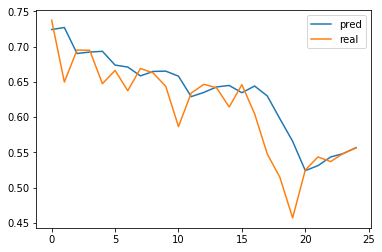

In [11]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

plt.plot(np.array(out)[:,0],label = 'pred')
plt.plot(np.array(out)[:,1],label = 'real')
plt.legend()